In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression, Ridge, LassoCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import RFECV, SelectFromModel
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.externals.six import StringIO
import graphviz
import pydotplus
from IPython.display import Image 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor

### 評価結果
- はじめに本レポートでの評価結果を記載する。(実際の数値の算出は以下のコードを参照のこと）
- データは8割を学習データ、2割を検証用データとして分割した。
- 評価指標はRMSEを用いた。
- 説明変数には標準化を適用した。
- 説明変数を削除せず、単純に線形回帰モデルを用いた場合、RMSEは0.891であった。
#### 1. フィルタ法
- 説明変数(speed)削除時  : 0.931
#### 2. ラッパー法(ステップワイズ法)
- 重要度の低い説明変数3つ(temp_inside, sun, distance)削除時 : 0.891
#### 3. 埋め込み法
- 重みの小さい説明変数(distance)削除時：0.893
#### 以下の評価ではパラメータは削除せずに評価した。
#### 4. 決定木
- RMSE : 0.877
#### 5. ランダムフォレスト
- RMSE : 0.714
#### 6. アダブースト
- RMSE : 0.754
#### ここまでの評価の結果、（説明変数を削除せずに）ランダムフォレストを実行した結果が、最も低い値となった。

### 1. データ準備

In [2]:
# CSVファイルを読み込む
df_consume = pd.read_csv("../1_data/measurements.csv")
df_consume.head()

,distance,consume,speed,temp_inside,temp_outside,specials,gas_type,AC,rain,sun,refill liters,refill gas
0,28,5,26,"21,5",12,NaN,E10,0,0,0,45,E10
1,12,"4,2",30,"21,5",13,NaN,E10,0,0,0,NaN,NaN
2,"11,2","5,5",38,"21,5",15,NaN,E10,0,0,0,NaN,NaN
3,"12,9","3,9",36,"21,5",14,NaN,E10,0,0,0,NaN,NaN
4,"18,5","4,5",46,"21,5",15,NaN,E10,0,0,0,NaN,NaN


In [3]:
# 分析に使えない列を削除する
df_consume_ext = df_consume.drop(["specials", "refill liters", "refill gas"], axis=1)

In [4]:
# 「,」 を 「.」に置換する
df_consume_ext["distance"] = df_consume_ext["distance"].str.replace(",", ".")
df_consume_ext["consume"] = df_consume_ext["consume"].str.replace(",", ".")
df_consume_ext["temp_inside"] = df_consume_ext["temp_inside"].str.replace(",", ".")

In [5]:
# 型を変換する
df_consume_ext["distance"] = df_consume_ext["distance"].astype(float)
df_consume_ext["consume"] = df_consume_ext["consume"].astype(float)
df_consume_ext["temp_inside"] = df_consume_ext["temp_inside"].astype(float)
df_consume_ext.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 388 entries, 0 to 387
Data columns (total 9 columns):
distance        388 non-null float64
consume         388 non-null float64
speed           388 non-null int64
temp_inside     376 non-null float64
temp_outside    388 non-null int64
gas_type        388 non-null object
AC              388 non-null int64
rain            388 non-null int64
sun             388 non-null int64
dtypes: float64(3), int64(5), object(1)
memory usage: 27.4+ KB


In [6]:
# 目的変数consumeが左端にくるよう列の順番を入れ替える
df_consume_ext = df_consume_ext.iloc[:,[1,0,2,3,4,5,6,7,8]]

In [7]:
# データを確認する
#df_consume_ext.describe()

In [8]:
# temp_insideの値を確認する
#df_consume_ext["temp_inside"].value_counts()

In [9]:
# temp_insideの欠損レコードを削除する。（388→376レコードになる）
df_consume_ext = df_consume_ext.dropna(subset=['temp_inside'])

In [10]:
df_consume_ext.describe()

,consume,distance,speed,temp_inside,temp_outside,AC,rain,sun
count,376.000000,376.000000,376.000000,376.000000,376.000000,376.000000,376.00000,376.000000
mean,4.925266,19.797340,41.957447,21.929521,11.340426,0.079787,0.12500,0.082447
std,1.040705,22.988878,13.714354,1.010455,7.066999,0.271325,0.33116,0.275411
min,3.300000,1.300000,14.000000,19.000000,-5.000000,0.000000,0.00000,0.000000
25%,4.300000,11.800000,32.000000,21.500000,6.000000,0.000000,0.00000,0.000000
50%,4.700000,14.600000,40.500000,22.000000,10.000000,0.000000,0.00000,0.000000
75%,5.300000,19.000000,50.000000,22.500000,16.000000,0.000000,0.00000,0.000000
max,12.200000,216.100000,90.000000,25.500000,31.000000,1.000000,1.00000,1.000000


### 2. フィルタ法の確認

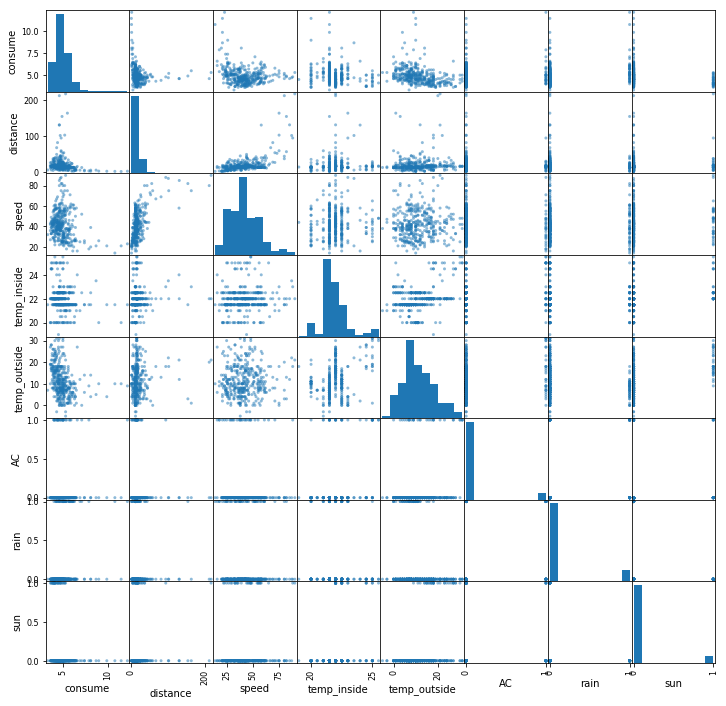

In [11]:
#散布図行列を確認する
pd.plotting.scatter_matrix(df_consume_ext, figsize=(12,12))
plt.show()

In [12]:
# 相関係数を確認する
df_consume_ext[["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]].corr()

,distance,speed,temp_inside,temp_outside,AC,rain,sun
distance,1.000000,0.565505,0.075305,0.086774,-0.027670,-0.022129,0.078627
speed,0.565505,1.000000,0.059725,0.019327,-0.036351,-0.002936,0.077181
temp_inside,0.075305,0.059725,1.000000,0.361308,0.297775,-0.037356,0.246120
temp_outside,0.086774,0.019327,0.361308,1.000000,0.169374,-0.185731,0.349988
AC,-0.027670,-0.036351,0.297775,0.169374,1.000000,0.244848,0.090164
rain,-0.022129,-0.002936,-0.037356,-0.185731,0.244848,1.000000,-0.113298
sun,0.078627,0.077181,0.246120,0.349988,0.090164,-0.113298,1.000000


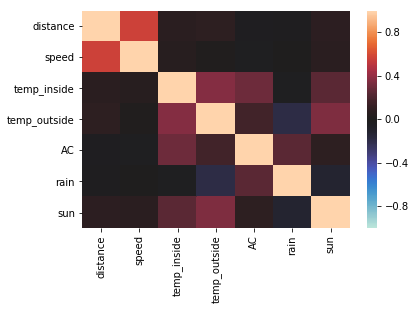

In [13]:
# 色で確認する
sns.heatmap(df_consume_ext[["distance", "speed", "temp_inside", "temp_outside", "AC", "rain", "sun"]].corr(),vmax=1, vmin =-1,center=0)

- speedとdistanceの相関が0.56とやや強い。

In [14]:
# 目的変数(consume)を格納する
y = df_consume_ext["consume"].values
# 説明変数(consume以外)を格納する
X = df_consume_ext[['distance', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain', 'sun']].values

In [15]:
# データを学習用と検証用に分ける
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=1234)

In [16]:
# 標準化を行う
stdsc = StandardScaler()
stdsc.fit(X_train)
X_train_std = stdsc.transform(X_train)
X_test_std = stdsc.transform(X_test)

- speedを説明変数から省いた状態での汎化誤差を出してみる。

In [17]:
X_train_less = np.delete(X_train_std, 1, 1)
X_test_less = np.delete(X_test_std, 1, 1)

In [18]:
l_regr = LinearRegression(fit_intercept=True)
l_regr.fit(X_train_less, y_train)
y_pred = l_regr.predict(X_test_less)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("speed削除時RMSE={:.3f}".format(rmse))

speed削除時RMSE=0.931


In [19]:
# speedを削除しない場合
l_regr.fit(X_train, y_train)
y_pred = l_regr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE={:.3f}".format(rmse))

RMSE=0.891


- speedに関していえば、削除しない方が、汎化誤差は小さい。

### 3.ラッパー法（ステップワイズ法）の確認

In [20]:
# 学習用データで学習する
regr = LinearRegression(fit_intercept=True)
rfecv = RFECV(regr, cv=5, scoring='neg_mean_absolute_error')## レコード数が少ないので５分割とする
rfecv.fit(X_train_std,y_train)

RFECV(cv=5,
   estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False),
   min_features_to_select=1, n_jobs=None,
   scoring='neg_mean_absolute_error', step=1, verbose=0)

In [21]:
print('feature ranking\n{}'.format(rfecv.ranking_))

feature ranking
[7 2 5 1 3 4 6]


- 説明変数のランキングはtemp_outside > speed > AC > rain > temp_inside > sun > distanceとなった。（左の方が重要）


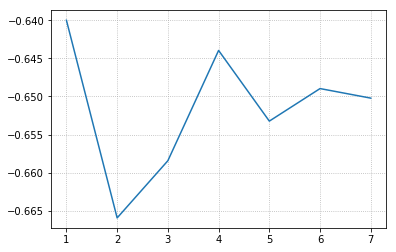

In [22]:
plt.plot(range(1, len(rfecv.ranking_)+1), rfecv.grid_scores_ )
plt.grid(which='major', linestyle=':')
plt.show()

- 説明変数が4個の方が、５～７個ある場合より、誤差が小さい。→temp_insideとsunとdistanceは削除してみる。
- なぜか説明変数が１個（temp_outside）のみの場合の誤差が小さい結果となった。

In [23]:
# temp_inside、sun、distanceを削除する
X_train_less = np.delete(X_train_std, [0,2,6], 1)
X_test_less = np.delete(X_test_std, [0,2,6], 1)

In [24]:
l_regr.fit(X_train_less, y_train)
y_pred = l_regr.predict(X_test_less)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("3つ削除時RMSE={:.3f}".format(rmse))

3つ削除時RMSE=0.891


In [25]:
# temp_outside以外全て削除する
X_train_less = np.delete(X_train_std, [0,1,2,4,5,6], 1)
X_test_less = np.delete(X_test_std, [0,1,2,4,5,6], 1)
l_regr.fit(X_train_less, y_train)
y_pred = l_regr.predict(X_test_less)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("temp_outsideのみ時RMSE={:.3f}".format(rmse))

temp_outsideのみ時RMSE=0.953


### 4. 埋め込み法(LASSO)の確認

In [26]:
estimator = LassoCV(normalize=False, cv=10)
sfm = SelectFromModel(estimator, threshold=1e-5)
sfm.fit(X_train, y_train)

SelectFromModel(estimator=LassoCV(alphas=None, copy_X=True, cv=10, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
    positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False),
        max_features=None, norm_order=1, prefit=False, threshold=1e-05)

In [27]:
sfm.get_support()

array([ True,  True,  True,  True,  True,  True,  True])

In [28]:
# 重みを出力する
omomi = sfm.estimator_.coef_
omomi

array([ 0.00089837, -0.0168743 , -0.07704468, -0.04161427,  0.54623743,
        0.3697569 , -0.1352671 ])

<BarContainer object of 7 artists>

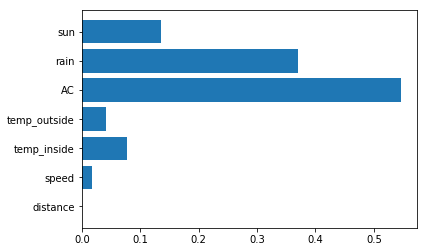

In [29]:
label = df_consume_ext.drop(["consume", "gas_type"], axis=1).columns
plt.barh(np.arange(0, len(omomi)), abs(omomi), tick_label=label)

- distanceはなくても予測に影響を与えないようである。

In [30]:
# distanceを削除する
X_train_less = np.delete(X_train_std, 0, 1)
X_test_less = np.delete(X_test_std, 0, 1)

In [31]:
l_regr.fit(X_train_less, y_train)
y_pred = l_regr.predict(X_test_less)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("distance削除時RMSE={:.3f}".format(rmse))

distance削除時RMSE=0.893


- ここまでの評価でdistance、temp_inside、sunを削除してもRMSEが0.891と削除前と変わらないことがわかった。

In [32]:
# temp_inside、sun、distanceを削除する
X_train_less = np.delete(X_train_std, [0,2,6], 1)
X_test_less = np.delete(X_test_std, [0,2,6], 1)

### 5. 決定木の確認

In [33]:
treeRgr = DecisionTreeRegressor(max_depth=None, min_samples_split=3, min_samples_leaf=3, random_state=1234)

In [34]:
treeRgr.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=3,
           min_samples_split=3, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best')

In [35]:
print("score=", treeRgr.score(X_train, y_train))
print("score2=", treeRgr.score(X_test, y_test))

score= 0.8342747608328644
score2= 0.19875760037831736


In [36]:
# 予測値を算出する
y_pred = treeRgr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#mae = mean_absolute_error(y_test, y_pred)
print("MSE={:.3f}".format(mse))
#print("MAE={:.3f}".format(mae))
print("RMSE={:.3f}".format(rmse))

MSE=0.769
RMSE=0.877


In [37]:
## 説明変数の重要度を確認する
feature = treeRgr.feature_importances_
feature

array([0.75177412, 0.09307612, 0.01019566, 0.11835204, 0.01299594,
       0.00745428, 0.00615183])

<BarContainer object of 7 artists>

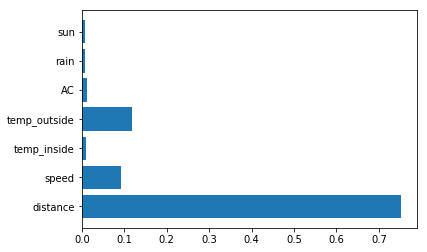

In [38]:
plt.barh(np.arange(0, len(feature)), feature, tick_label=label)

- 決定木でみるとdistanceの値が回帰において重要な要素となっていることがわかる。
- ステップワイズ法とLASSOではほとんど結果に影響を与えないという判定だったがどう解釈すれば良いのだろうか？

In [39]:
label

Index(['distance', 'speed', 'temp_inside', 'temp_outside', 'AC', 'rain',
       'sun'],
      dtype='object')

In [40]:
# 生成された木構造を確認してみる
dot_data = StringIO()
export_graphviz(treeRgr, out_file=dot_data, feature_names=label, filled=True, rounded=True, special_characters=True)

In [41]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

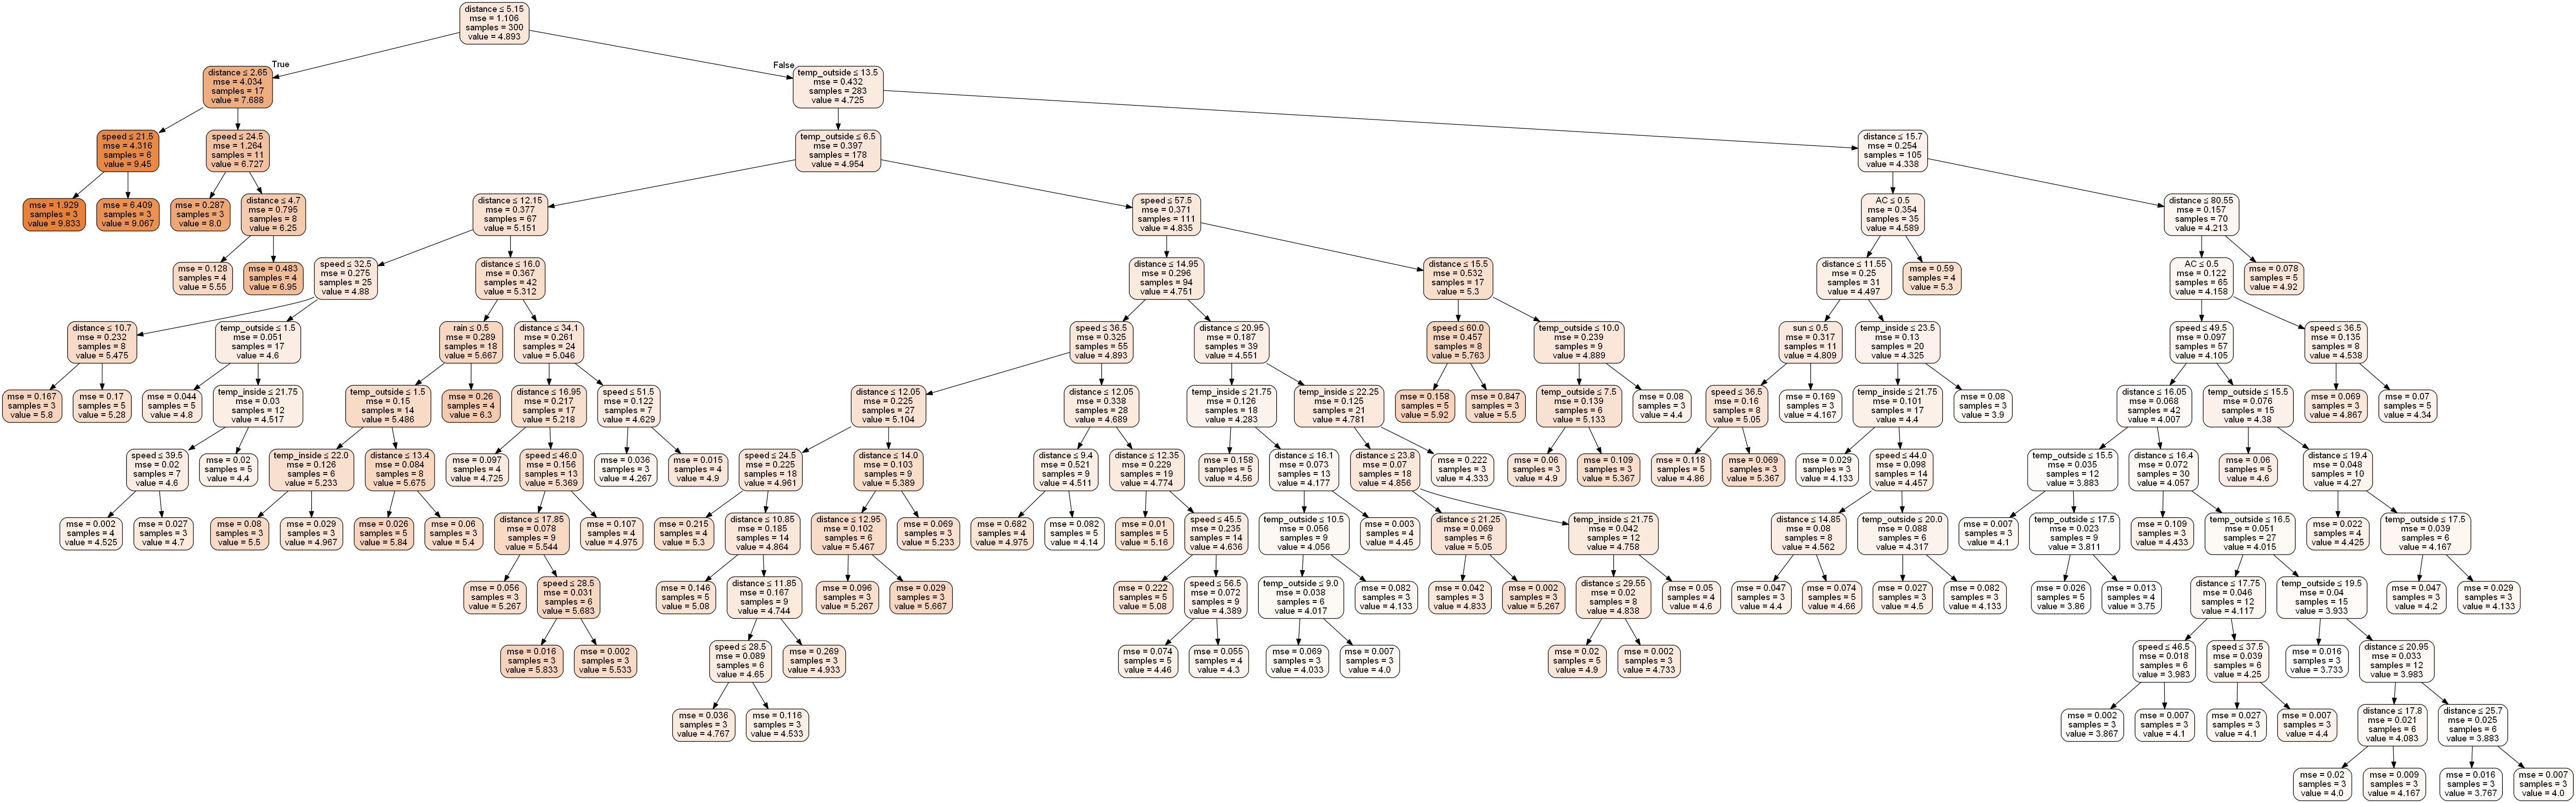

In [42]:
Image(graph.create_png())

### 6. ランダムフォレストの確認

In [43]:
clf = RandomForestRegressor(n_estimators=10, max_depth=2, min_samples_leaf=2, min_samples_split=2, random_state=1234)

In [44]:
clf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=2, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=1234, verbose=0, warm_start=False)

In [45]:
print("score=", clf.score(X_train, y_train))
print("score2=", clf.score(X_test, y_test))

score= 0.6196469035228707
score2= 0.469453634038458


In [46]:
# 予測値を算出する
y_pred = clf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("MSE={:.3f}".format(mse))
#print("MAE={:.3f}".format(mae))
print("RMSE={:.3f}".format(rmse))

MSE=0.509
RMSE=0.714


In [47]:
#重要度を確認する
df_feature = pd.DataFrame(clf.feature_importances_, index=label)

In [48]:
display(df_feature)

,0
distance,0.781957
speed,0.009484
temp_inside,0.018378
temp_outside,0.190181
AC,0.000000
rain,0.000000
sun,0.000000


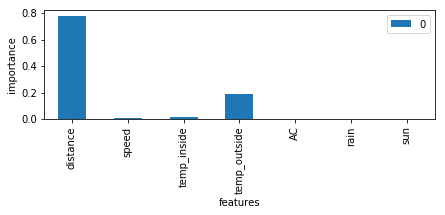

In [49]:
df_feature.plot.bar(figsize=(7,2))
plt.xlabel('features')
plt.ylabel('importance')
plt.show()

- ランダムフォレストでもdistanceの重要度が高い

### 7.アダブーストの確認

In [50]:
treeRgr = DecisionTreeRegressor(max_depth=3, min_samples_leaf=2, min_samples_split=2, random_state=1234)
adaRgr = AdaBoostRegressor(treeRgr, n_estimators=10, random_state=1234)

In [51]:
adaRgr.fit(X_train, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=3, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=2,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=1234, splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=10,
         random_state=1234)

In [52]:
print("score=", adaRgr.score(X_train, y_train))
print("score2=", adaRgr.score(X_test, y_test))

score= 0.7311320018666847
score2= 0.40809056019488665


In [53]:
# 予測値を算出する
y_pred = adaRgr.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
print("MSE={:.3f}".format(mse))
print("MAE={:.3f}".format(mae))
print("RMSE={:.3f}".format(rmse))

MSE=0.568
MAE=0.552
RMSE=0.754


In [54]:
#重要度を確認する
df_feature = pd.DataFrame(adaRgr.feature_importances_, index=label)

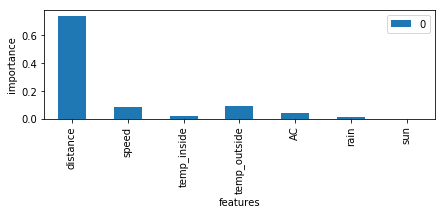

In [55]:
df_feature.plot.bar(figsize=(7,2))
plt.xlabel('features')
plt.ylabel('importance')
plt.show()